<a href="https://colab.research.google.com/github/Bitdribble/dlwpt-code/blob/master/colab/PyTorchCh8_Layer_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [2]:
# Data preparation
data_path = '.'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [3]:
# Normalize data
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [4]:
# Restrict data to airplanes and birds
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

In [5]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [25]:
def training_loop(n_epochs, device, optimizer, model, loss_fn, train_loader, val_loader, log_epochs=0):
  hist = {
      "loss_train" : [],
      "acc_train" : [],
      "acc_val" : [],
  }

  for epoch in range(1, n_epochs + 1):
    model.train() # Set train mode
    loss_train = 0.0

    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)

      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()

    loss_train /= len(train_loader)
    acc_train, acc_val = validate(model, device, train_loader, val_loader)

    hist["loss_train"].append(loss_train)
    hist["acc_train"].append(acc_train)
    hist["acc_val"].append(acc_val)

    if log_epochs is not 0 and (epoch % log_epochs == 0 or epoch == n_epochs):
      print(f"{datetime.datetime.now()} Epoch {epoch}, "
            f"Loss train {loss_train:.3f} Acc train {acc_train:.3f} val {acc_val:.3f}")
      
  return hist

def validate(model, device, train_loader, val_loader):
  acc = {}
  model.eval() # Set eval mode

  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    with torch.no_grad(): 
      for imgs, labels in loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)

        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1) 

        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    acc[name] = correct / total
  
  return acc["train"], acc["val"]

In [11]:
# This implements Layer Normalization 
class NetLayerNorm(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()

    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1) # TO DO: change to layer norm
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
    self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1//2)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)

    self.fc1 = nn.Linear(8*8*(n_chans1//2), 32)
    self.act3 = nn.Tanh()

    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1_batchnorm(self.conv1(x))))
    out = self.pool2(self.act2(self.conv2_batchnorm(self.conv2(out))))
    out = out.view(-1, 8*8*(self.n_chans1//2)) # In place of nn.Flatten()
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

In [28]:
model = NetLayerNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, 
                                         shuffle=False)

loss_fn = nn.CrossEntropyLoss()

model.train() # Set train mode

hist = training_loop(
    n_epochs = 40,
    device=device,
    optimizer = optimizer,
    model = model,

    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    log_epochs = 1
)

2022-01-31 01:05:48.734934 Epoch 1, Loss train 0.472 Acc train 0.804 val 0.817
2022-01-31 01:05:49.498285 Epoch 2, Loss train 0.381 Acc train 0.846 val 0.844
2022-01-31 01:05:50.250511 Epoch 3, Loss train 0.352 Acc train 0.855 val 0.848
2022-01-31 01:05:50.999964 Epoch 4, Loss train 0.337 Acc train 0.859 val 0.845
2022-01-31 01:05:51.766413 Epoch 5, Loss train 0.323 Acc train 0.869 val 0.854
2022-01-31 01:05:52.521241 Epoch 6, Loss train 0.310 Acc train 0.849 val 0.857
2022-01-31 01:05:53.273263 Epoch 7, Loss train 0.304 Acc train 0.871 val 0.860
2022-01-31 01:05:54.035161 Epoch 8, Loss train 0.288 Acc train 0.876 val 0.867
2022-01-31 01:05:54.790467 Epoch 9, Loss train 0.280 Acc train 0.886 val 0.864
2022-01-31 01:05:55.528506 Epoch 10, Loss train 0.274 Acc train 0.875 val 0.863
2022-01-31 01:05:56.291062 Epoch 11, Loss train 0.270 Acc train 0.858 val 0.840
2022-01-31 01:05:57.052967 Epoch 12, Loss train 0.262 Acc train 0.862 val 0.832
2022-01-31 01:05:57.810264 Epoch 13, Loss train 0

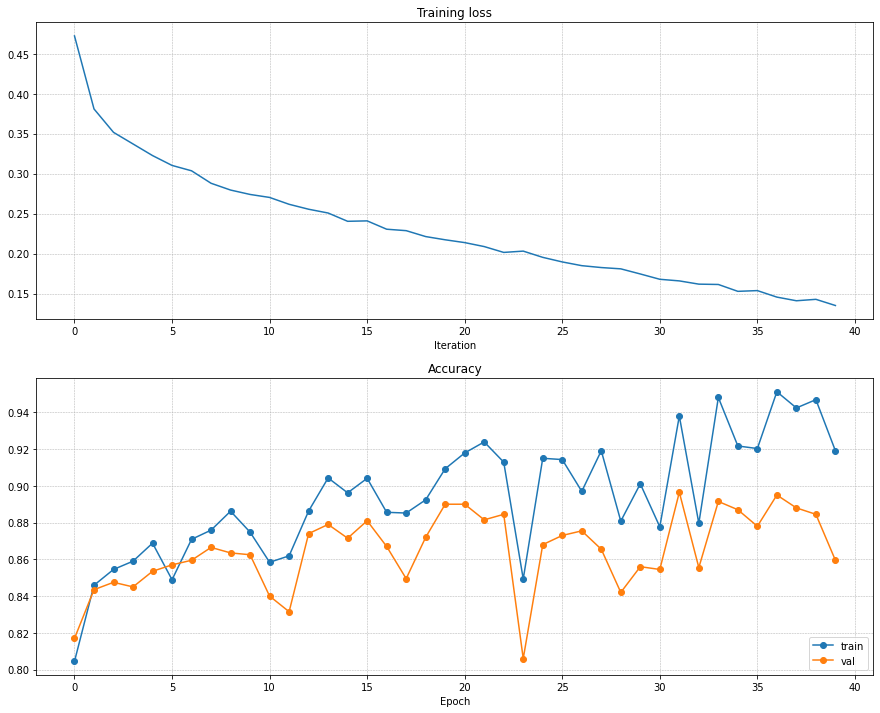

In [29]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(hist["loss_train"])
plt.xlabel('Iteration')
plt.grid(linestyle='--', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(hist["acc_train"], '-o', label='train')
plt.plot(hist["acc_val"], '-o', label='val')
#plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.grid(linestyle='--', linewidth=0.5)
plt.show()